# Develop Regression Models for Soil Properties Estimation

In [1]:
import os

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from sklearn import preprocessing
import tensorflow as tf
import tensorflow_probability as tfp

### Load data

In [2]:
DATA_DIR = '/home/daitran/Desktop/git/soil_properties/data'

ntb_data_path = os.path.join(DATA_DIR, 'NTB_black_data.csv')
tb_data_path = os.path.join(DATA_DIR, 'TB_blue_data.csv')

ntb_data= pd.read_csv(ntb_data_path)
tb_data = pd.read_csv(tb_data_path)

### Data pre-processing

In [3]:
assign_num_list = {'topsoil layer': 0,
                      'weathered rock': 1,
                      'hard rock': 2,
                      'soft rock': 3,
                      'weathered soil': 4,
                      'colluvial layer': 5,
                      'moderate rock': 6,
                      'sedimentary layer': 7,
                      'reclaimed layer': 8,
                      'uncertain': 9}

In [4]:
ntb_names = ntb_data['Soi properties (main)']
tb_names = tb_data['Soi properties (main)']

ntb_target = ntb_names.replace(assign_num_list)
tb_target = tb_names.replace(assign_num_list)

ntb_data['Target'] = ntb_target
tb_data['Target'] = tb_target

X_train_ntb = ntb_data[['X','Y','Elevation']].to_numpy()
y_train_ntb = ntb_data['Target'].to_numpy()

X_train_tb = tb_data[['X','Y','Elevation']].to_numpy()
y_train_tb = tb_data['Target'].to_numpy()

# https://scikit-learn.org/stable/modules/preprocessing.html
normalizer = preprocessing.MinMaxScaler()

normalized_X_train_ntb = normalizer.fit_transform(X_train_ntb)
normalized_X_train_tb = normalizer.fit_transform(X_train_tb)

# Deterministic Models

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

###  ANN

In [6]:
def create_model(dim):
    model = Sequential([
        Dense(10, activation = 'relu', kernel_initializer='he_normal', input_dim = dim),
        Dense(1, kernel_initializer='normal', activation='linear')
    ])
    
    model.compile(loss='mean_squared_error',
              optimizer=tf.optimizers.Adam(learning_rate=0.001))
    
    return model

In [7]:
def get_checkpoint_best_only(model_type = 'deterministic'):
    current_dir = os.getcwd()
    if model_type:
        checkpoint_path = current_dir + "/checkpoints_best_only_{}/checkpoint".format(model_type)

    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                frequency = "epoch",
                                save_weights_only = True,
                                monitor = "mean_squared_error",
                                save_best_ony = True,
                                verbose = 1)
    return checkpoint

In [8]:
def get_early_stopping():
    early_stopping = EarlyStopping(monitor = "loss", mode ="min", patience = 5)
    return early_stopping 
    

In [9]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

In [10]:
callbacks = [checkpoint_best_only, early_stopping]

In [11]:
model = create_model(dim = 3)

### Train

In [12]:
%%time
hist = model.fit(normalized_X_train_ntb, y_train_ntb, 
                  epochs = 100, verbose=1,
                batch_size=10,
                callbacks=callbacks)
#                 validation_data=(normalized_X_train_tb,y_train_tb))

Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 25.8202

Epoch 00001: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic/checkpoint
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 23.4303

Epoch 00002: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic/checkpoint
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 23.2935

Epoch 00003: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic/checkpoint
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 21.1481

Epoch 00004: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic/checkpoint
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 19.8483

Epoch 00005: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic/checkpoint


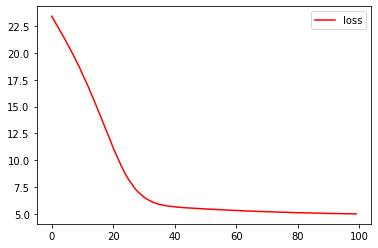

In [13]:
plt.plot(hist.history['loss'],'r',label='loss')
# plt.plot(hist.history['val_loss'],'b',label='val_loss')
plt.legend()
plt.show()


# Probabilistic models

In the deterministic models, we develop ANN's weights with a single value. However, the true value of this weight is not certion. Because we have too little data points, therefor the training data contains its uncertainty. So, we have to develop the model that can handle the uncertainty in deep learning models. This is done by changing each weight from a single deterministic value to a probability distribution.

### Create the pror and posterior distribution for model weights

In [14]:
tfd = tfp.distributions
tfpl = tfp.layers

In [15]:
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(
            lambda t : tfd.MultivariateNormalDiag(loc = tf.zeros(n), scale_diag = tf.ones(n))
        )
    ])
    return prior_model

In [16]:
def posterior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype = dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

In [17]:
model_prob = Sequential([
    tfpl.DenseVariational(units=20,
                          input_shape=(3,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/normalized_X_train_ntb.shape[0],
                          activation='relu'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/normalized_X_train_ntb.shape[0]),
    tfpl.IndependentNormal(1)
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.


In [18]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_prob.compile(loss=nll, optimizer=tf.optimizers.Adam(learning_rate=0.001))
model_prob.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 20)                3320      
_________________________________________________________________
dense_variational_1 (DenseVa (None, 2)                 945       
_________________________________________________________________
independent_normal (Independ multiple                  0         
Total params: 4,265
Trainable params: 4,265
Non-trainable params: 0
_________________________________________________________________


In [19]:
normalized_X_train_ntb_d =  tf.constant(normalized_X_train_ntb, dtype=tf.float64)

In [20]:
# tf.dtypes.cast(normalized_X_train_ntb_d, tf.float64)

In [21]:
y_train_ntb_d =  tf.constant(y_train_ntb, dtype=tf.float64)

In [22]:
# tf.dtypes.cast(y_train_ntb_d, tf.float64)

In [23]:
tf.config.run_functions_eagerly(True)

In [24]:
checkpoint_best_only = get_checkpoint_best_only(model_type = 'probabilistic')
callbacks_prob = [checkpoint_best_only]

In [25]:
his_prob = model_prob.fit(normalized_X_train_ntb_d, y_train_ntb_d,
                     epochs=100, verbose=1,
#                      batch_size = 10,
                     callbacks=callbacks_prob
                         )

Epoch 1/100
1/3 [=========>....................] - ETA: 0s - loss: 5.0706

/home/daitran/miniconda3/envs/probability/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


3/3 [==============================] - 0s 102ms/step - loss: 320.7632

Epoch 00001: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_probabilistic/checkpoint
Epoch 2/100
3/3 [==============================] - 0s 103ms/step - loss: 73.4279

Epoch 00002: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_probabilistic/checkpoint
Epoch 3/100
3/3 [==============================] - 0s 101ms/step - loss: 320.5510

Epoch 00003: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_probabilistic/checkpoint
Epoch 4/100
3/3 [==============================] - 0s 129ms/step - loss: 33.0393

Epoch 00004: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_probabilistic/checkpoint
Epoch 5/100
3/3 [==============================] - 0s 109ms/step - loss: 667.9381

Epoch 00005: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_probabilistic/checkpoint
Epoch 6/1

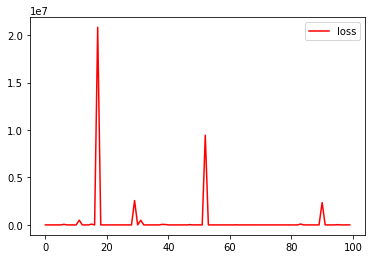

In [26]:
plt.plot(his_prob.history['loss'],'r',label='loss')
# plt.plot(hist.history['val_loss'],'b',label='val_loss')
plt.legend()
plt.show()


In [28]:
def get_model_best_epoch(model, model_type):
    current_dir = os.getcwd()
    if model_type:
        checkpoint_path = current_dir + "/checkpoints_best_only_{}/checkpoint".format(model_type)
    
    model.load_weights(checkpoint_path)
    
    return model

In [29]:
model_best = get_model_best_epoch(model_prob, model_type = 'probabilistic')

In [30]:
y_predict = np.around(model_best.predict(normalized_X_train_ntb)).astype(int)

In [31]:
y_predict[y_predict < 0] = 9

In [32]:
y_predict[y_predict > 8] = 9

In [33]:
def plot_data(x, y, labels, colours):
    
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(20, 10))
    
    ax = fig.add_subplot(121, projection='3d')

    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
    ax = fig.add_subplot(122, projection='3d')
    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
        ax.view_init(90, 0)   
        
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

In [34]:
labels = {}
for k, v in assign_num_list.items():
    labels[v] = k

In [35]:
label_colours = ['blue', 'green', 'red', 'cyan',
                 'magenta', 'yellow', 'black', 'brown', 
                 'pink','silver']

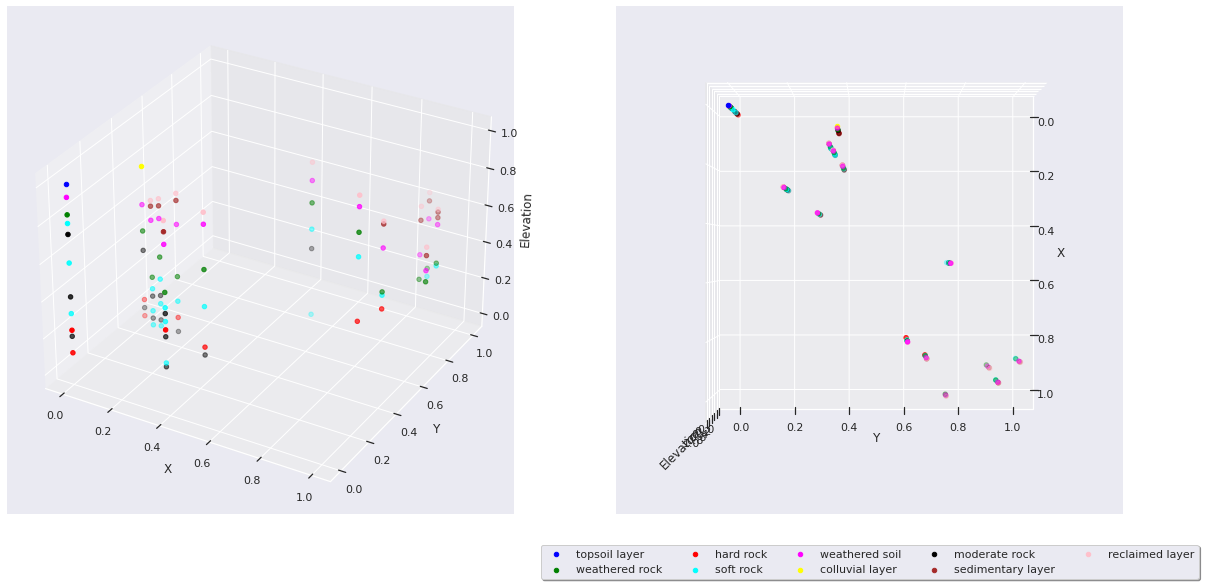

In [36]:
plot_data(normalized_X_train_ntb, y_train_ntb, labels, label_colours)
plt.show()

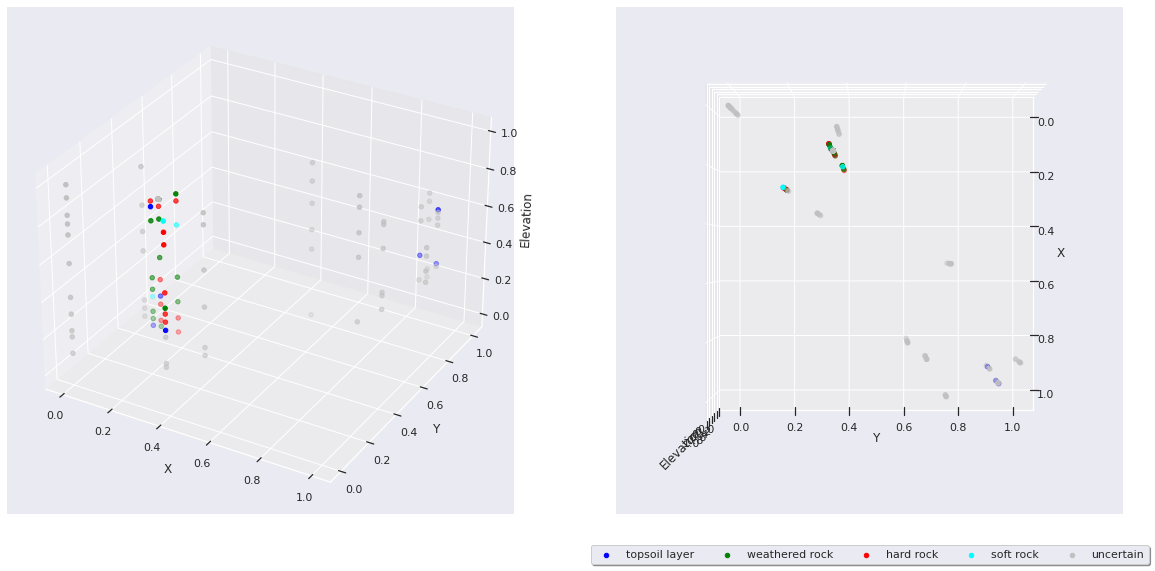

In [37]:
plot_data(normalized_X_train_ntb, y_predict, labels, label_colours)
plt.show()